In [1]:
import datetime
import pathlib
from scipy.io import arff
import pandas as pd
import urllib.request
import io # for io.StringIO()
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn import datasets
import seaborn as sn

Read the hepatitis data with pandas package, since it allows reading directly from website. Clean the data and remove points that contain "?"(missing data)

In [2]:
hepatitis=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data",header=None)
print("Matrix before filtering: " , hepatitis.shape)
hepatitis=hepatitis[hepatitis.eq('?').any(1)==False]
print("Matrix after filtering: " , hepatitis.shape)
#print(hepatitis)

Matrix before filtering:  (155, 20)
Matrix after filtering:  (80, 20)


# 新段落

Convert the data frame to float data type, since pandas automatically considers some variables as "str" or some non-numerical types. Compute the correlation between each two covariates and find the maximum.

[[2 34 1 ... '4.0' '75' 1]
 [2 39 1 ... '4.4' '85' 1]
 [2 32 1 ... '3.7' '54' 1]
 ...
 [2 31 1 ... '4.2' '54' 2]
 [2 53 2 ... '4.1' '48' 2]
 [1 43 1 ... '3.1' '42' 2]]
          0         1         2         3         4         5         6   \
0   1.000000 -0.212769  0.175876  0.123830 -0.108776  0.181151  0.275595   
1  -0.212769  1.000000 -0.046265  0.016022 -0.043308 -0.111171 -0.074306   
2   0.175876 -0.046265  1.000000  0.016354 -0.091777 -0.064686  0.019558   
3   0.123830  0.016022  0.016354  1.000000  0.058313  0.068224  0.168270   
4  -0.108776 -0.043308 -0.091777  0.058313  1.000000 -0.038716 -0.008018   
5   0.181151 -0.111171 -0.064686  0.068224 -0.038716  1.000000  0.583660   
6   0.275595 -0.074306  0.019558  0.168270 -0.008018  0.583660  1.000000   
7  -0.185042  0.243440 -0.035579  0.021031 -0.011934  0.308257  0.528145   
8  -0.194030 -0.034422 -0.020908  0.191683  0.122253  0.039072 -0.002608   
9   0.055978 -0.167090 -0.129018  0.097744  0.058313  0.225663  0.065510

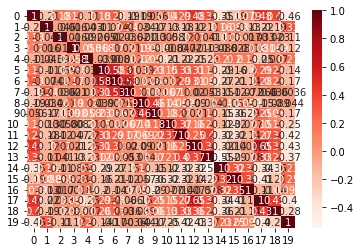

In [3]:
hepatitis_corr=hepatitis.values[:,:]
print(hepatitis_corr)
hepatitis_corr=hepatitis_corr.astype(float)
hepatitis_corr=pd.DataFrame(hepatitis_corr)
pd.set_option("display.max_rows", None, "display.max_columns", None)
cor=hepatitis_corr.corr()
print(cor)
sn.heatmap(cor, annot=True, cmap=plt.cm.Reds)

Code for initializing a tree structure(Copied from tutorial)

In [4]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2,axis = -1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
minkowski = lambda x1, x2: np.power(np.sum(np.abs(x1 - x2)**3,axis = -1), 1/3)

class KNN:
    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn                                                    #we need to use self because the parameters would be stored in variables 
                                                                                  #on the stack and would be discarded when the init method goes out of scope
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
                
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        # print("The shape of the distances is", distances.shape)                          
        #When operating on two arrays, NumPy compares their shapes element-wise. 
        #It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when: they are equal, or one of them is 1

        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]  
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K                                                          #nd you just divided by K so that we scale the value from zero to 1.
        return y_prob, knns
     

In [5]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    
        self.left = None                                  
        self.right = None                                   
        self.split_feature = None                           
        self.split_value = None                             
        if parent:
            self.depth = parent.depth + 1                    
            self.num_classes = parent.num_classes      
            self.data = parent.data                         
            self.labels = parent.labels                     
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) 
            self.class_prob = class_prob / np.sum(class_prob)  
            

Algorithm for bulding a tree

In [6]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [7]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [8]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

In [9]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [10]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

In [11]:
def evaluate_acc(y_test,y_pred):
  return np.sum(y_pred == y_test)/y_test.shape[0]


Subset the two covariates with the largest correlation as parameters to be examined by decision tree.

In [12]:
x, y = hepatitis.values[:,[12,17]], hepatitis.values[:,:1]
y=y.ravel()
x=x.astype(float)
y=y.astype(int)

(num_instances, num_features), num_classes = x.shape, np.max(y)+1
np.random.seed(1234)
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:60]], y[inds[:60]]
x_test, y_test = x[inds[60:]], y[inds[60:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

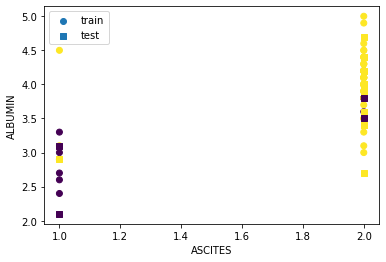

In [13]:
#visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('ALBUMIN')
plt.xlabel('ASCITES')
plt.show()

1


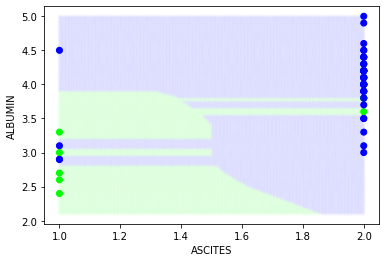

2


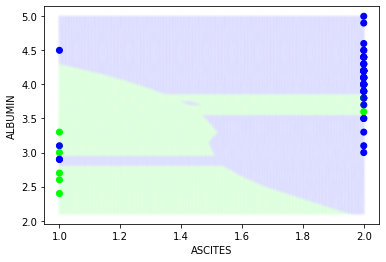

3


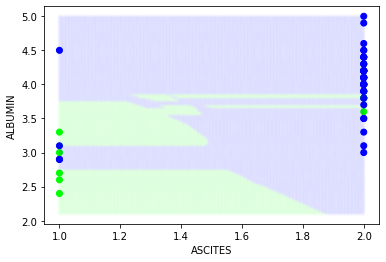

4


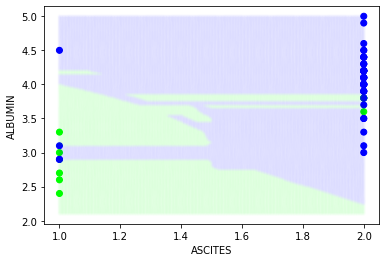

5


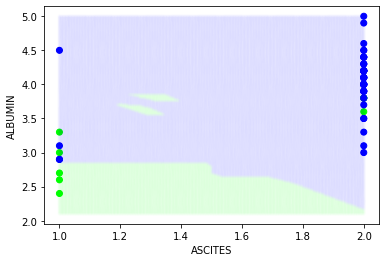

6


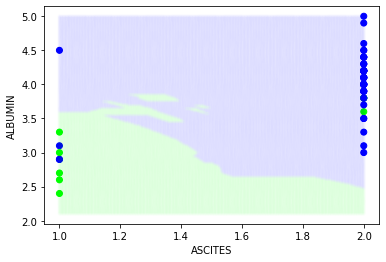

7


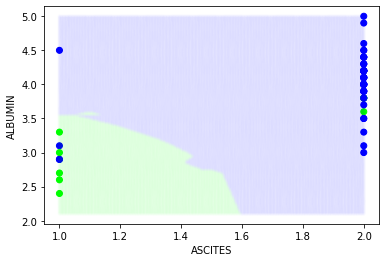

8


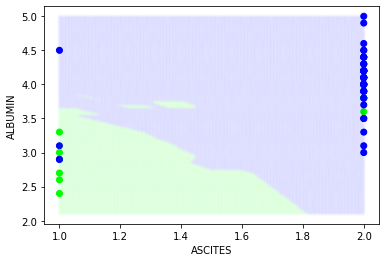

9


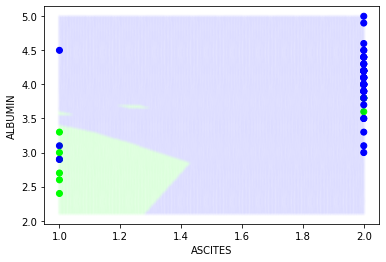

10


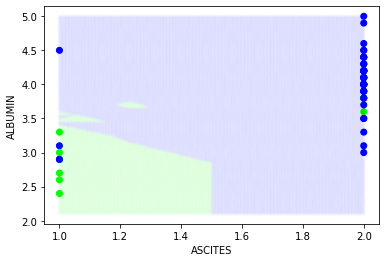

11


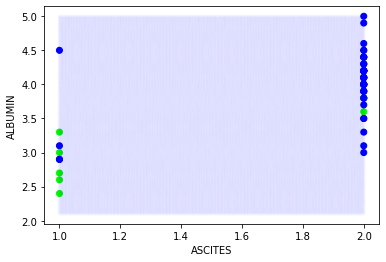

12


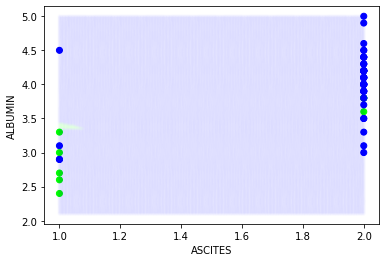

13


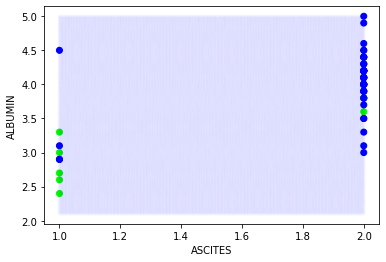

14


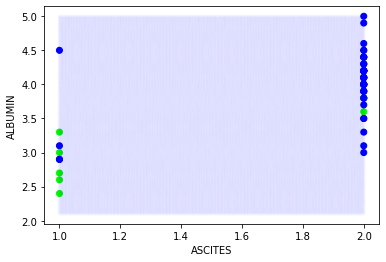

15


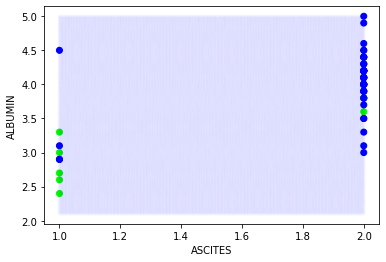

16


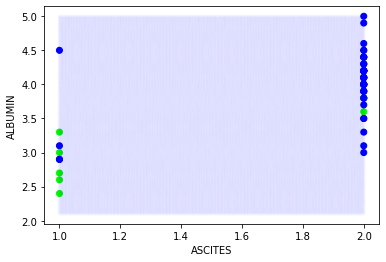

17


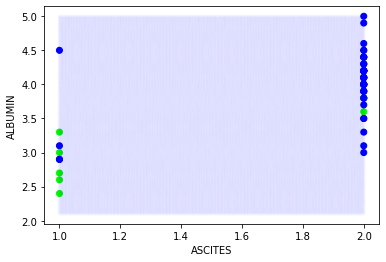

18


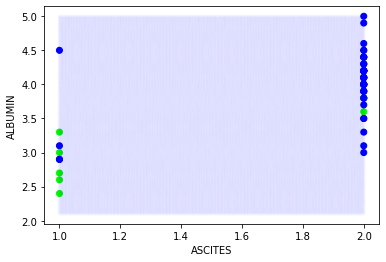

19


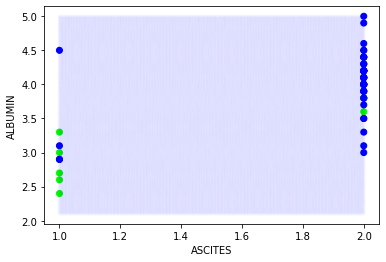

20


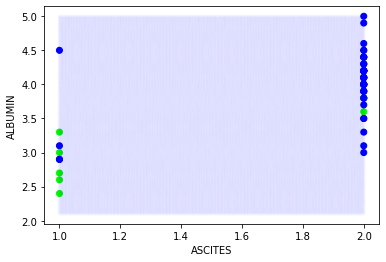

21


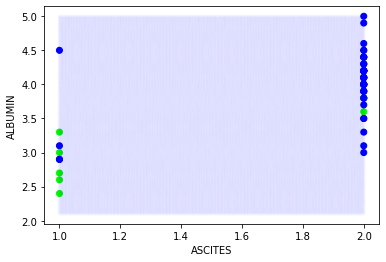

22


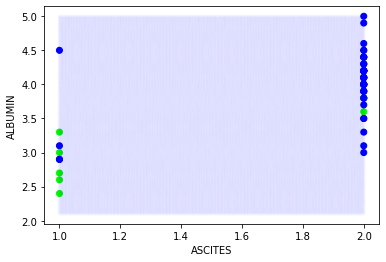

23


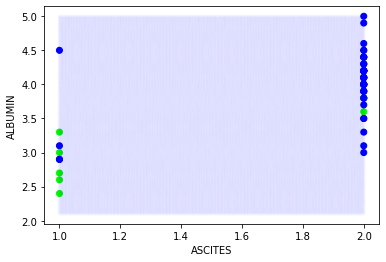

24


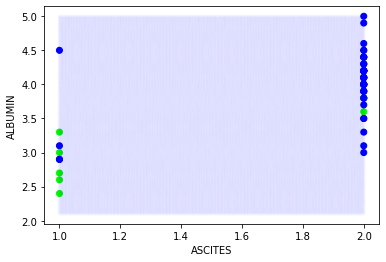

25


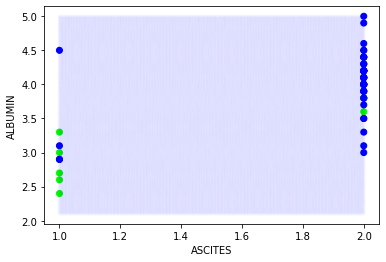

26


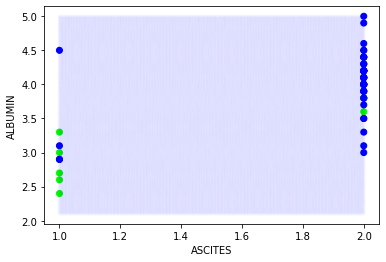

27


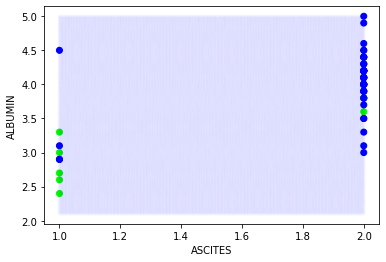

28


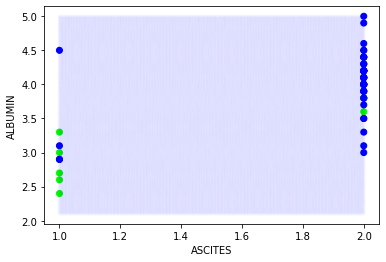

29


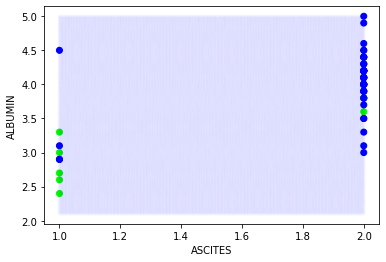

30


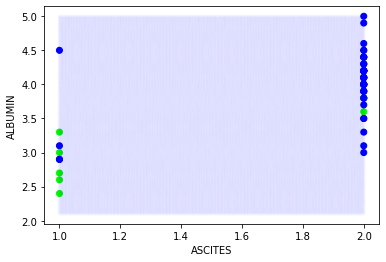

31


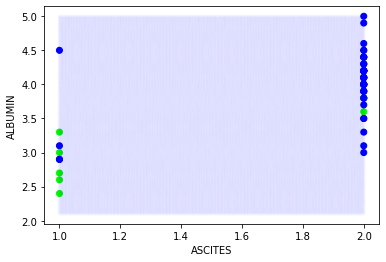

32


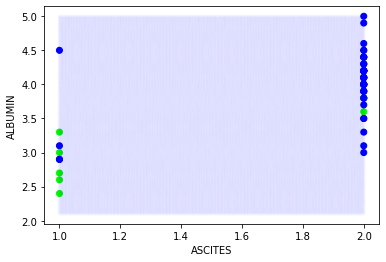

33


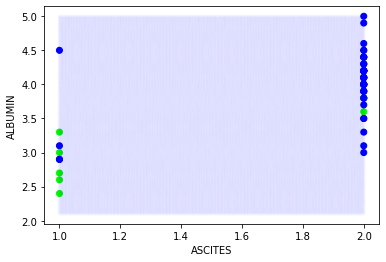

34


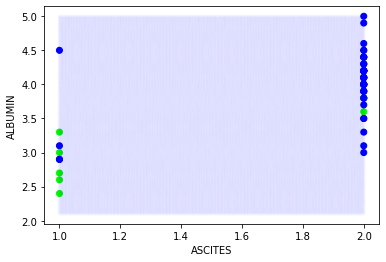

35


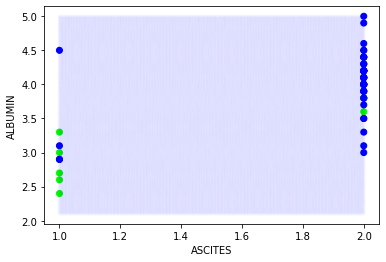

36


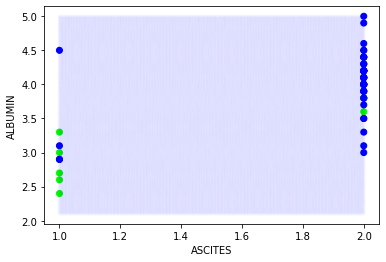

37


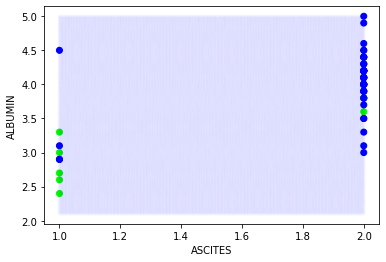

38


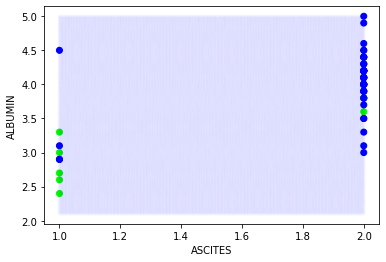

39


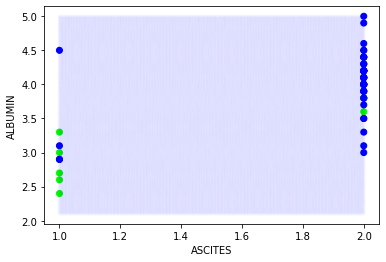

40


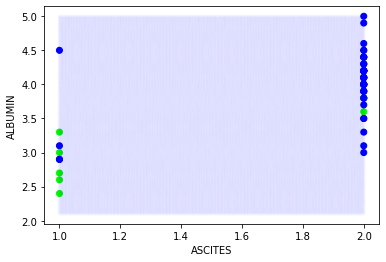

41


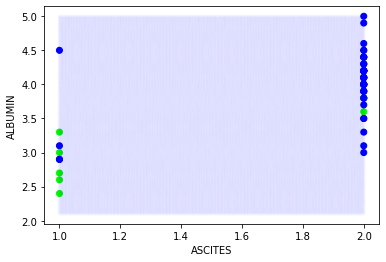

42


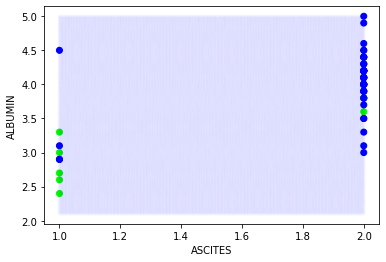

43


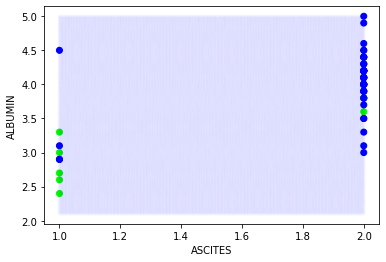

44


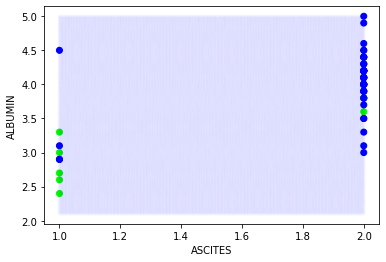

45


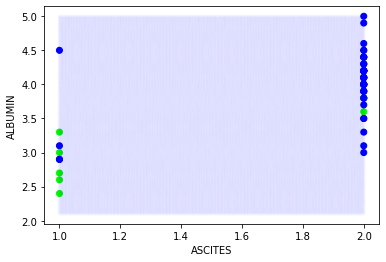

46


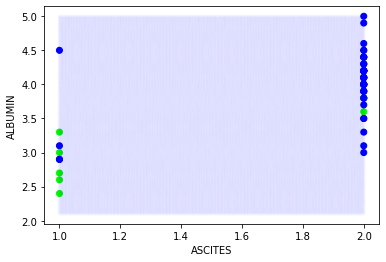

47


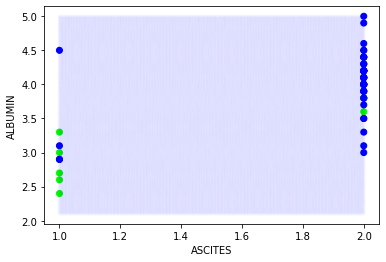

48


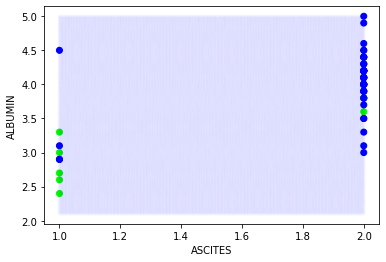

49


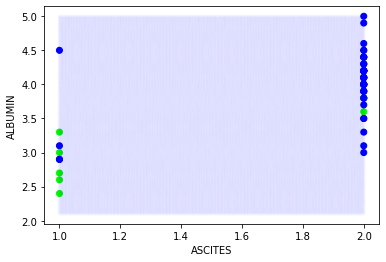

50


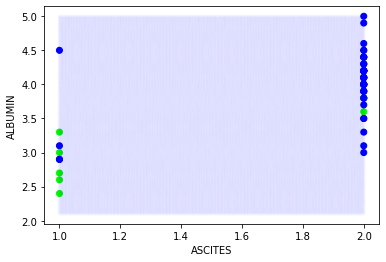

51


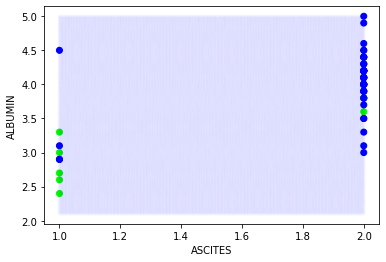

52


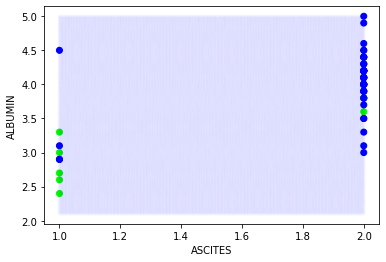

53


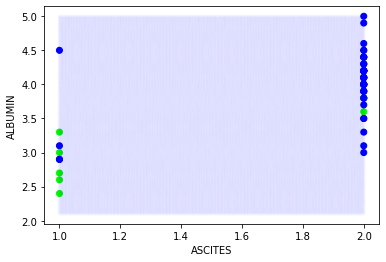

54


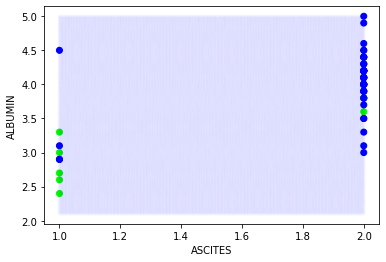

55


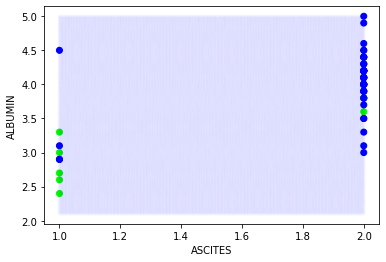

56


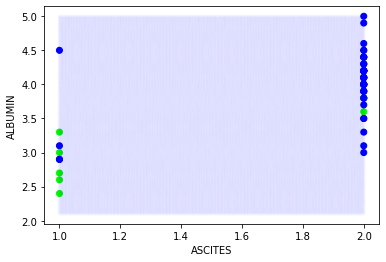

57


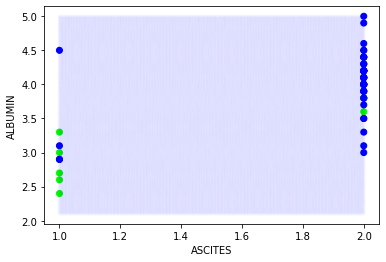

58


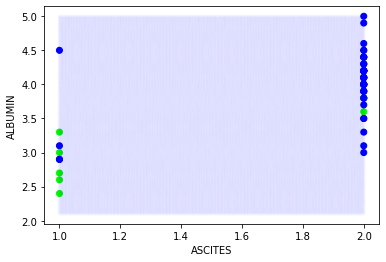

59


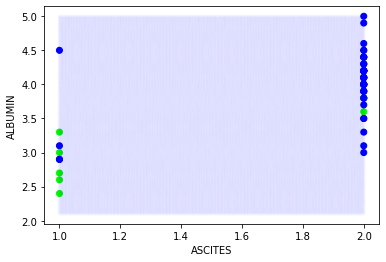

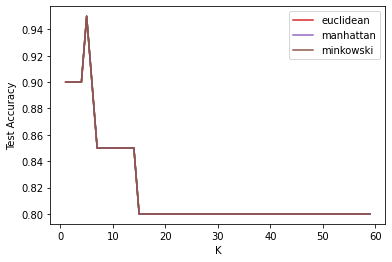

0.95
0.95
0.95
5
.     
5
.     
5
For KNN, 
Max accuracy is 0.95 when K=5
Min accuracy is 0.8 when K=15


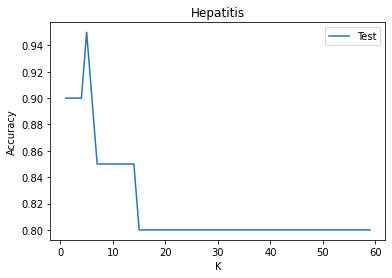

In [15]:
acc_lst, K_lst = [], []
acc_lst_m = []
acc_lst_m1 = []
for k in range(1, 60):
    model_m1 = KNN(k, dist_fn = minkowski)
    model_m = KNN(k, dist_fn=manhattan)
    model = KNN(k)
    y_prob, knns = model.fit(x, y).predict(x_test)
    y_prob_m, knns_m = model_m.fit(x, y).predict(x_test)
    y_prob_m1, knns_m1 = model_m1.fit(x, y).predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    y_pred_m = np.argmax(y_prob_m, axis=-1)
    y_pred_m1 = np.argmax(y_prob_m1, axis=-1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    accuracy_m = np.sum(y_pred_m == y_test) / y_test.shape[0]
    accuracy_m1 = np.sum(y_pred_m1 == y_test) / y_test.shape[0]
    acc_lst.append(accuracy)
    acc_lst_m.append(accuracy_m)
    acc_lst_m1.append(accuracy_m1)
    K_lst.append(k)
    
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  #to get class probability of all the points in the 2D grid
    print(k)
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
    plt.ylabel('ALBUMIN')
    plt.xlabel('ASCITES')
    plt.show()
#plot accuracy graph for different distance function
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.plot(K_lst, acc_lst)
plt.plot(K_lst, acc_lst_m)
plt.plot(K_lst, acc_lst_m1)
line1, = plt.plot(K_lst, acc_lst, label='euclidean')
line2, = plt.plot(K_lst, acc_lst_m, label='manhattan')
line3, = plt.plot(K_lst, acc_lst_m1, label='minkowski')
plt.legend(handles=[line1, line2,line3], loc='upper right')
plt.show()
print(max(acc_lst))
print(max(acc_lst_m))
print(max(acc_lst_m1))
for i in range(len(acc_lst)):
  if (acc_lst[i] == max(acc_lst)):
    print(i+1)
    break;

print(".     ")
for i in range(len(acc_lst_m)):
  if (acc_lst_m[i] == max(acc_lst_m)):
    print(i+1)
    break;
print(".     ")
for i in range(len(acc_lst_m1)):
  if (acc_lst_m1[i] == max(acc_lst_m1)):
    print(i+1)
    break;
  
# gives the max min accuracy for KNN 
max_value = max(acc_lst)
max_index = acc_lst.index(max_value)
min_value = min(acc_lst)
min_index = acc_lst.index(min_value)

print(f'For KNN, ')
print(f'Max accuracy is {max_value} when K={max_index + 1}')
print(f'Min accuracy is {min_value} when K={min_index + 1}')

#plot graph KNN testing vs. training accuracy
plt.xlabel('K')
plt.ylabel('Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='Test')
plt.legend(handles=[line1], loc='upper right')
plt.title('Hepatitis')
plt.show()

#plot the decision boundary

1


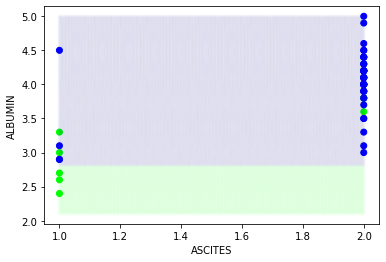

2


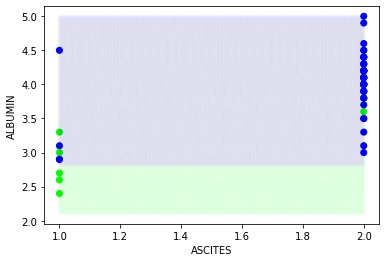

3


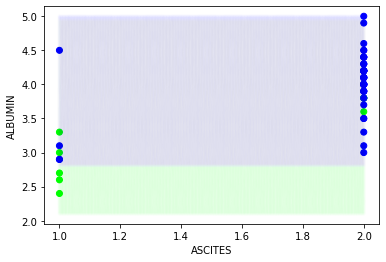

4


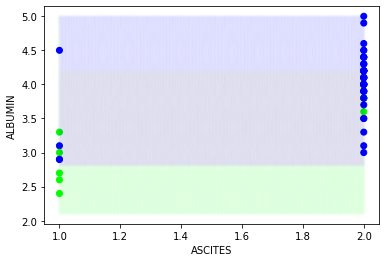

5


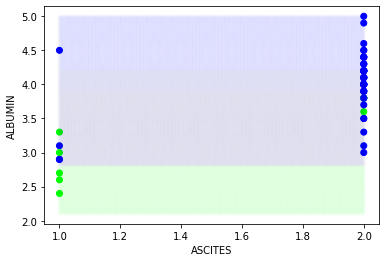

6


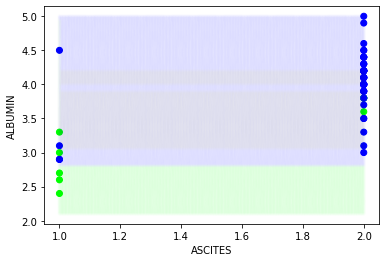

7


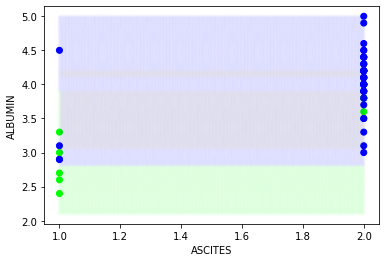

8


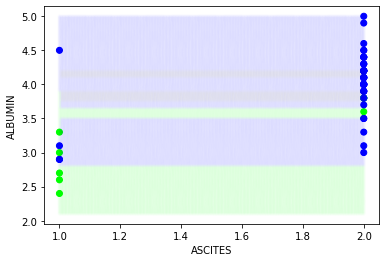

9


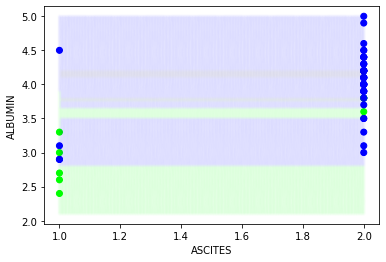

10


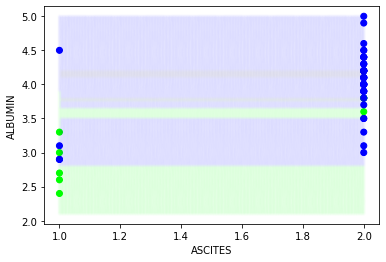

11


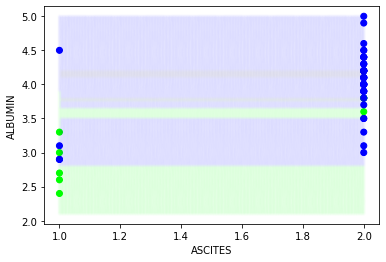

12


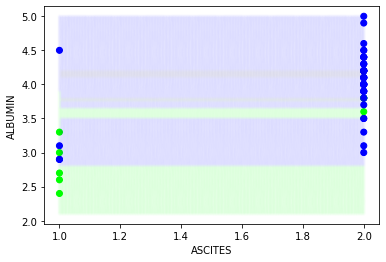

13


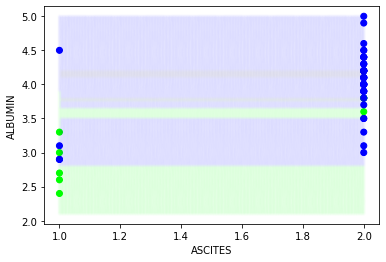

14


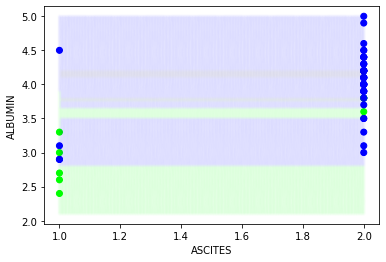

15


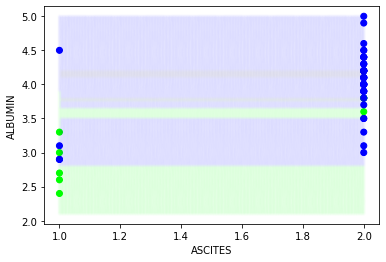

16


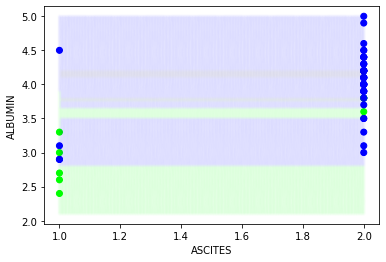

17


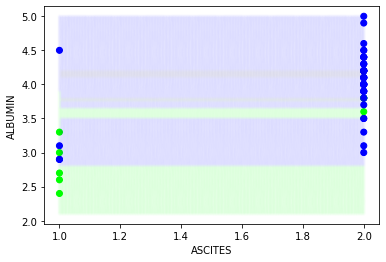

18


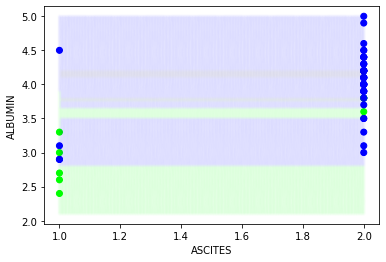

19


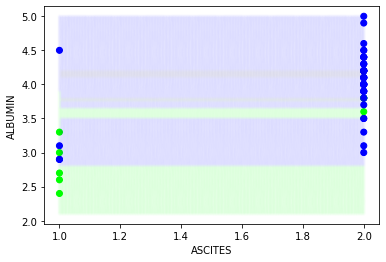

20


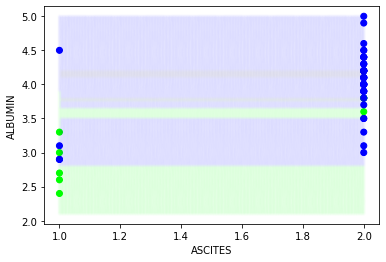

21


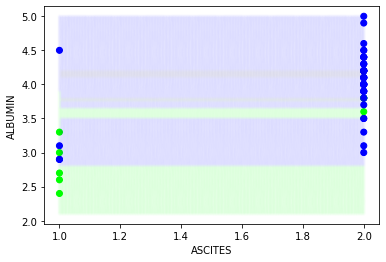

22


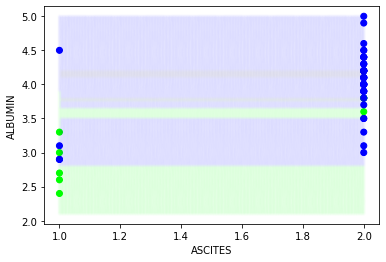

23


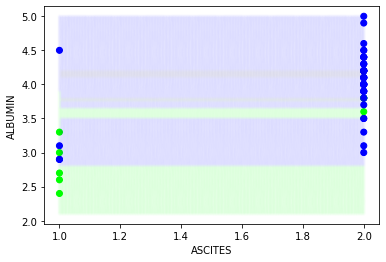

24


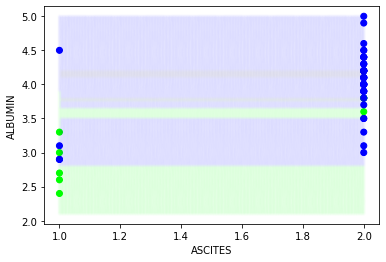

25


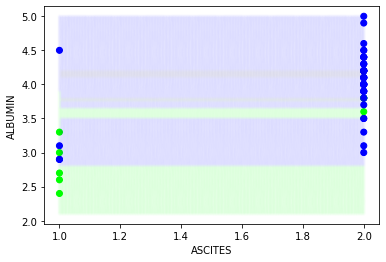

26


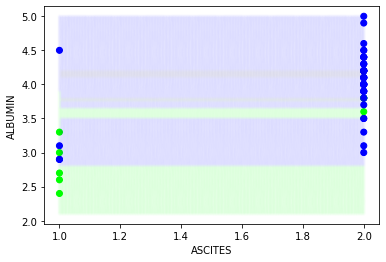

27


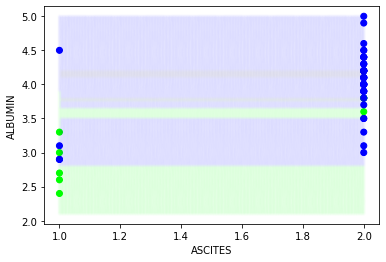

28


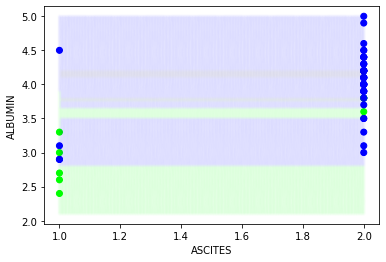

29


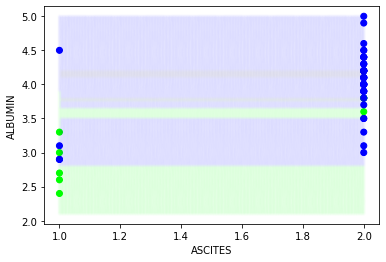

30


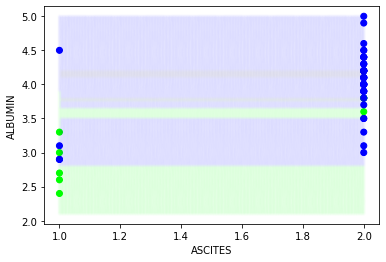

31


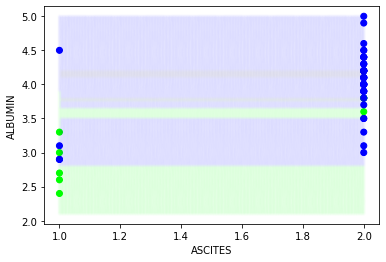

32


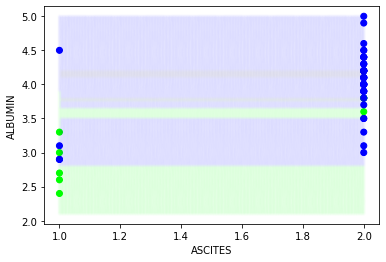

33


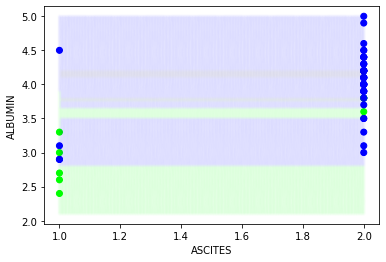

34


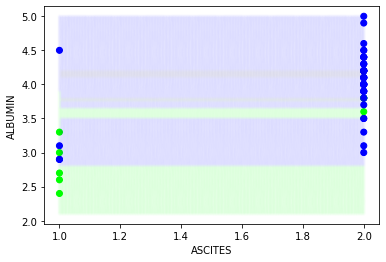

35


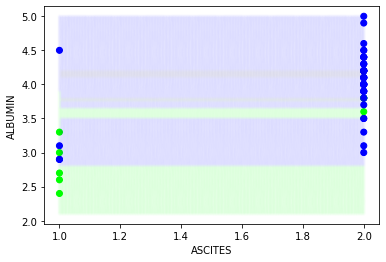

36


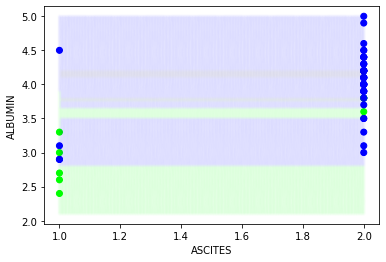

37


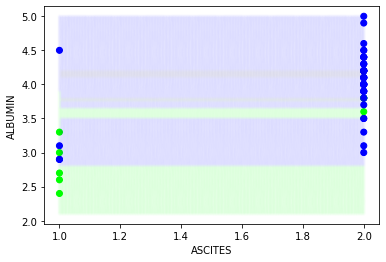

38


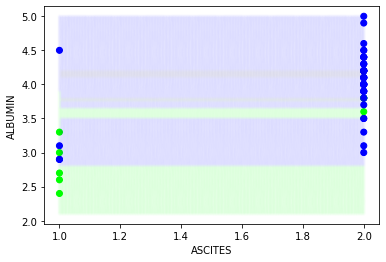

39


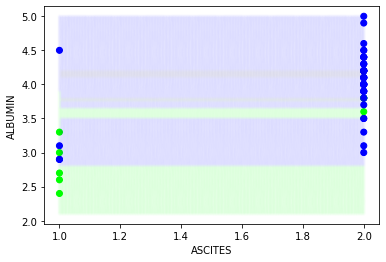

40


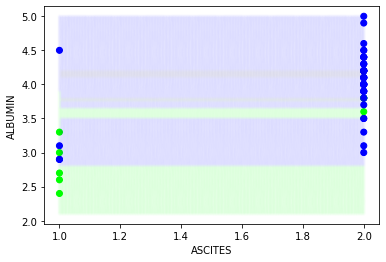

41


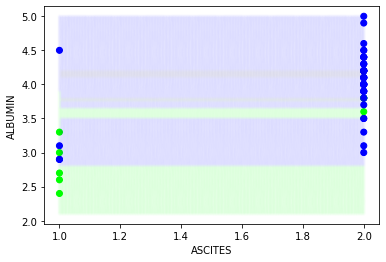

42


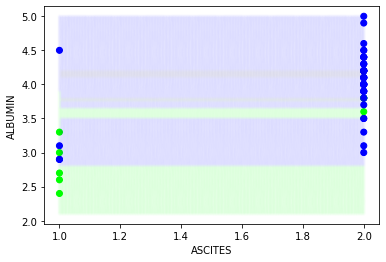

43


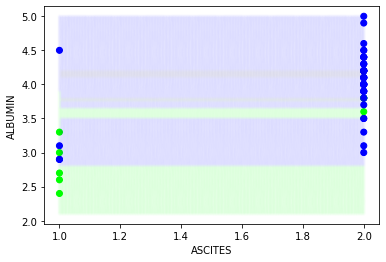

44


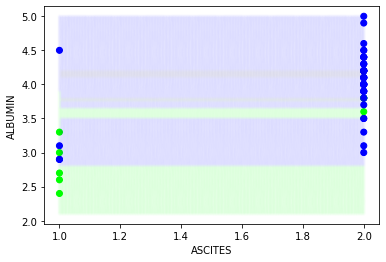

45


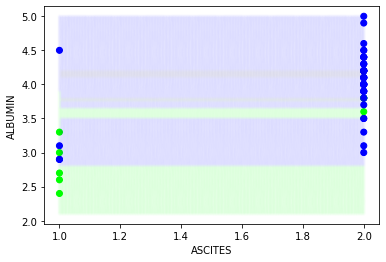

46


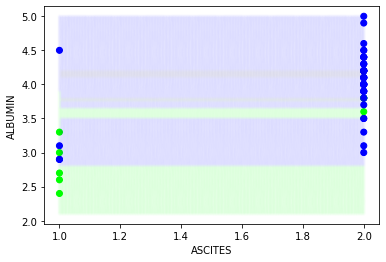

47


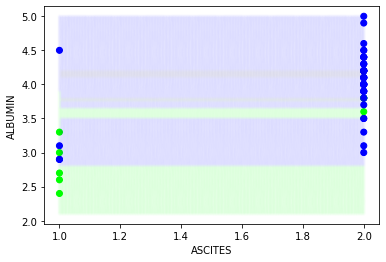

48


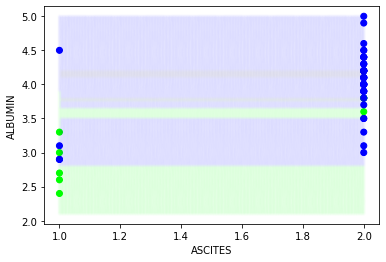

49


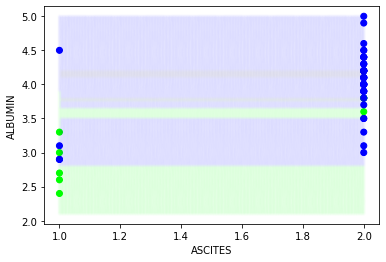

50


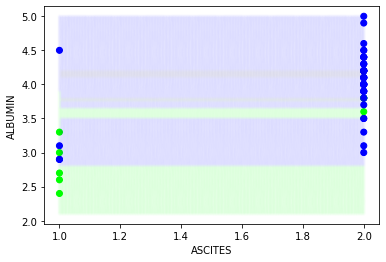

51


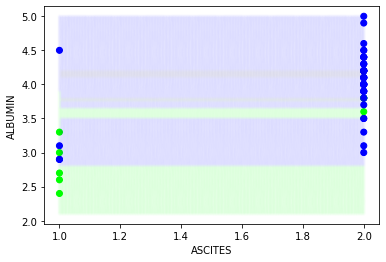

52


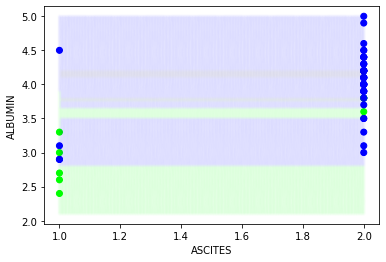

53


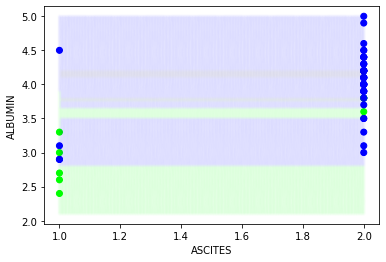

54


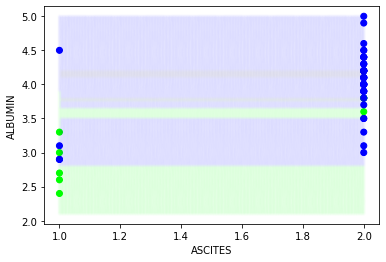

55


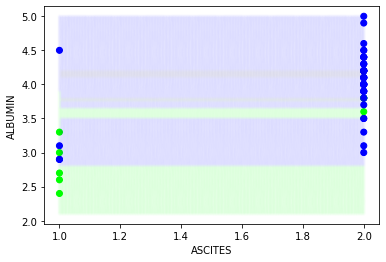

56


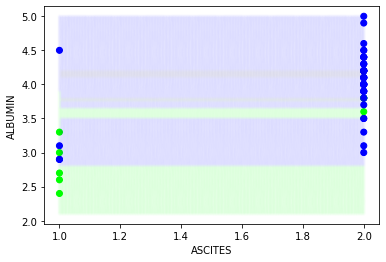

57


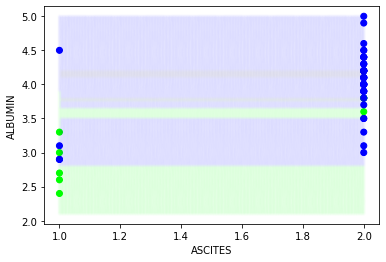

58


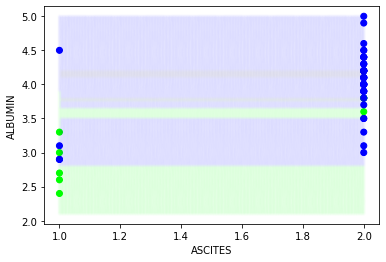

59


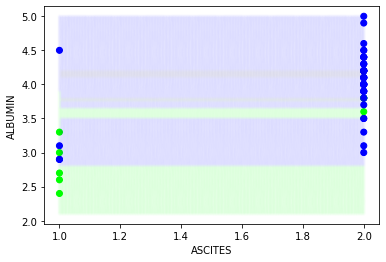

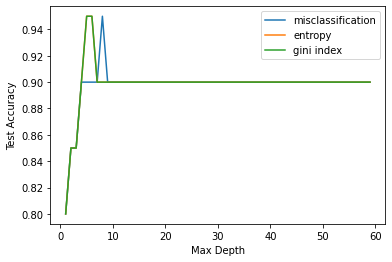

0.95
0.95
0.95
8
.     
5
.     
5
For DecisionTree, 
Max accuracy is 0.95 when max_depth is 8
Min accuracy is 0.8 when max_depth is 1


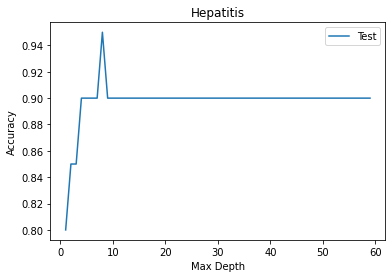

In [16]:
acc_lst = []
acc_lst_e = []
acc_lst_g = []
for mx_d in range(1, 60):
    tree = DecisionTree(max_depth=mx_d)
    tree_e = DecisionTree(max_depth=mx_d, cost_fn=cost_entropy)
    tree_g = DecisionTree(max_depth=mx_d, cost_fn=cost_gini_index)
    probs_test = tree.fit(x, y).predict(x_test)
    probs_test_e = tree_e.fit(x, y).predict(x_test)
    probs_test_g = tree_g.fit(x, y).predict(x_test)
    y_pred = np.argmax(probs_test, 1)
    y_pred_e = np.argmax(probs_test_e, 1)
    y_pred_g = np.argmax(probs_test_g, 1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    accuracy_e = np.sum(y_pred_e == y_test) / y_test.shape[0]
    accuracy_g = np.sum(y_pred_g == y_test) / y_test.shape[0]
    acc_lst.append(accuracy)
    acc_lst_e.append(accuracy_e)
    acc_lst_g.append(accuracy_g)
    #plot the decision boundary
    
      
    print(mx_d)
    y_train_prob = np.zeros((y_train.shape[0], num_classes))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    y_prob_all = tree.fit(x_train, y_train).predict(x_all)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
    plt.ylabel('ALBUMIN')
    plt.xlabel('ASCITES')
    plt.show()


#plot graph for different cost function
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='misclassification')
line2, = plt.plot([i for i in range(1, 60)], acc_lst_e, label='entropy')
line3, = plt.plot([i for i in range(1, 60)], acc_lst_g, label='gini index')
plt.legend(handles=[line1, line2, line3], loc='upper right')
plt.show()
print(max(acc_lst))
print(max(acc_lst_e))
print(max(acc_lst_g))
for i in range(len(acc_lst)):
  if (acc_lst[i] == max(acc_lst)):
    print(i+1)
    break;

print(".     ")
for i in range(len(acc_lst_e)):
  if (acc_lst_e[i] == max(acc_lst_e)):
    print(i+1)
    break;
print(".     ")
for i in range(len(acc_lst_g)):
  if (acc_lst_g[i] == max(acc_lst_g)):
    print(i+1)
    break;

#find the max and min training and testing value for DT
max_value = max(acc_lst)
max_index = acc_lst.index(max_value)
min_value = min(acc_lst)
min_index = acc_lst.index(min_value)


print(f'For DecisionTree, ')
print(f'Max accuracy is {max_value} when max_depth is {max_index + 1}')
print(f'Min accuracy is {min_value} when max_depth is {min_index + 1}')


#plot graph for DT training vs.testing accuracy
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
line1, = plt.plot([i for i in range(1, 60)], acc_lst, label='Test')
plt.legend(handles=[line1], loc='upper right')
plt.title('Hepatitis')
plt.show()